In [1]:
costable = [cos((2x+1)*u*pi/16) for x=0:7, u=0:7]

function dct2_scale(v, u)
    m = u == 0 ? 1/sqrt(2) : 1
    m *= v == 0 ? 1/sqrt(2) : 1
end

function dct2(s)
    [1/4 * dct2_scale(v,u) * 
        sum(Int8(s[y+1,x+1]*255 - 128) * costable[x+1,u+1] * costable[y+1,v+1] 
            for x=0:7, y=0:7) for v=0:7, u=0:7]
end

function idct2(S)
    [1/4 * 
        sum(dct2_scale(v, u) * S[v+1,u+1]
            * costable[x+1,u+1] * costable[y+1,v+1]
            for u=0:7, v=0:7)
    for y=0:7, x=0:7]
end

idct2 (generic function with 1 method)

In [33]:
q_table = [ 16  11  10  16  24  40  51  61;
            12  12  14  19  26  58  60  55;
            14  13  16  24  40  57  69  56;
            14  17  22  29  51  87  80  62;
            18  22  37  56  68 109 103  77;
            24  35  55  64  81 104 113  92;
            49  64  78  87 103 121 120 101;
            72  92  95  98 112 100 103  99 ]

q_factor = 2

q_table = UInt8.(round.(min.(q_table .* q_factor, 255)))
# q_table = ones(8, 8)

function quantize(S)
    R = Int16.(round.(S ./ q_table))
    R
end

function unquantize(S)
    S .* q_table .* q_factor
end

unquantize (generic function with 1 method)

In [34]:
q_table

8×8 Array{UInt8,2}:
 0x20  0x16  0x14  0x20  0x30  0x50  0x66  0x7a
 0x18  0x18  0x1c  0x26  0x34  0x74  0x78  0x6e
 0x1c  0x1a  0x20  0x30  0x50  0x72  0x8a  0x70
 0x1c  0x22  0x2c  0x3a  0x66  0xae  0xa0  0x7c
 0x24  0x2c  0x4a  0x70  0x88  0xda  0xce  0x9a
 0x30  0x46  0x6e  0x80  0xa2  0xd0  0xe2  0xb8
 0x62  0x80  0x9c  0xae  0xce  0xf2  0xf0  0xca
 0x90  0xb8  0xbe  0xc4  0xe0  0xc8  0xce  0xc6

In [35]:
for row = eachrow(q_table)
    for q = row
        print(string(q, base=16, pad=2), " ")
    end
    println()
end

20 16 14 20 30 50 66 7a 
18 18 1c 26 34 74 78 6e 
1c 1a 20 30 50 72 8a 70 
1c 22 2c 3a 66 ae a0 7c 
24 2c 4a 70 88 da ce 9a 
30 46 6e 80 a2 d0 e2 b8 
62 80 9c ae ce f2 f0 ca 
90 b8 be c4 e0 c8 ce c6 


In [36]:
struct ZigZagIter
    xs
end

function Base.iterate(it :: ZigZagIter)
    (it.xs[1, 1], (1,2,:downleft))
end

function Base.iterate(it :: ZigZagIter, (i, j, s))
    if (i, j) > size(it.xs)
        return nothing
    end
    
    ii = i
    jj = j
    ss = s
    
    if s == :downleft
        if i == size(it.xs)[1]
            jj = j + 1
            ss = :upright
        elseif j == 1
            ii = i + 1
            ss = :upright
        else
            ii = i + 1
            jj = j - 1
        end
    elseif s == :upright
        if j == size(it.xs)[2]
            ii = i + 1
            ss = :downleft
        elseif i == 1
            jj = j + 1
            ss = :downleft
        else
            ii = i - 1
            jj = j + 1
        end
    end
    
    (it.xs[i, j], (ii, jj, ss))
end

function Base.length(it :: ZigZagIter)
    length(it.xs)
end

In [37]:
function runlength_encode(S)
    num = 0    
    out = []
    
    for x = Iterators.drop(ZigZagIter(S), 1)
        if x == 0
            num += 1
        else
            while num > 15
                num -= 16
                push!(out, :zrl)
            end
            push!(out, (num, x))            
            num = 0
        end
    end
    
    if num != 0
        push!(out, :eob)
    end
    
    S[1,1], out
end

runlength_encode (generic function with 1 method)

In [38]:
ac_eob = [1, 0, 1, 0]

ac_zrl = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]

ac_lens = [
    2  2  3  4  5  7  8  10 16 16;
    4  5  7  9  11 16 16 16 16 16;
    5  8  10 12 16 16 16 16 16 16; 
    6  9  12 16 16 16 16 16 16 16; 
    6  10 16 16 16 16 16 16 16 16; 
    7  11 16 16 16 16 16 16 16 16; 
    7  12 16 16 16 16 16 16 16 16; 
    8  12 16 16 16 16 16 16 16 16; 
    9  15 16 16 16 16 16 16 16 16; 
    9  16 16 16 16 16 16 16 16 16; 
    9  16 16 16 16 16 16 16 16 16; 
    10 16 16 16 16 16 16 16 16 16; 
    10 16 16 16 16 16 16 16 16 16; 
    11 16 16 16 16 16 16 16 16 16; 
    16 16 16 16 16 16 16 16 16 16; 
    16 16 16 16 16 16 16 16 16 16;
]

ac_codes = [
    0x0000 0x0001 0x0004 0x000b 0x001a 0x0078 0x00f8 0x03f6 0xff82 0xff83;
    0x000c 0x001b 0x0079 0x01f6 0x07f6 0xff84 0xff85 0xff86 0xff87 0xff88;
    0x001c 0x00f9 0x03f7 0x0ff4 0xff89 0xff8a 0xff8b 0xff8c 0xff8d 0xff8e;
    0x003a 0x01f7 0x0ff5 0xff8f 0xff90 0xff91 0xff92 0xff93 0xff94 0xff95;
    0x003b 0x03f8 0xff96 0xff97 0xff98 0xff99 0xff9a 0xff9b 0xff9c 0xff9d;
    0x007a 0x07f7 0xff9e 0xff9f 0xffa0 0xffa1 0xffa2 0xffa3 0xffa4 0xffa5;
    0x007b 0x0ff6 0xffa6 0xffa7 0xffa8 0xffa9 0xffaa 0xffab 0xffac 0xffad;
    0x00fa 0x0ff7 0xffae 0xffaf 0xffb0 0xffb1 0xffb2 0xffb3 0xffb4 0xffb5;
    0x01f8 0x7fc0 0xffb6 0xffb7 0xffb8 0xffb9 0xffba 0xffbb 0xffbc 0xffbd;
    0x01f9 0xffbe 0xffbf 0xffc0 0xffc1 0xffc2 0xffc3 0xffc4 0xffc5 0xffc6;
    0x01fa 0xffc7 0xffc8 0xffc9 0xffca 0xffcb 0xffcc 0xffcd 0xffce 0xffcf;
    0x03f9 0xffd0 0xffd1 0xffd2 0xffd3 0xffd4 0xffd5 0xffd6 0xffd7 0xffd8;
    0x03fa 0xffd9 0xffda 0xffdb 0xffdc 0xffdd 0xffde 0xffdf 0xffe0 0xffe1;
    0x07f8 0xffe2 0xffe3 0xffe4 0xffe5 0xffe6 0xffe7 0xffe8 0xffe9 0xffea;
    0xffeb 0xffec 0xffed 0xffee 0xffef 0xfff0 0xfff1 0xfff2 0xfff3 0xfff4;
    0xfff5 0xfff6 0xfff7 0xfff8 0xfff9 0xfffa 0xfffb 0xfffc 0xfffd 0xfffe;
]

# column = size, row = run
ac_words = [digits(code, base=2, pad=len) |> reverse for (len, code) = zip(ac_lens, ac_codes)]

# code word for each dc difference category
dc_words = [
    [0, 0],
    [0, 1, 0],
    [0, 1, 1],
    [1, 0, 0],
    [1, 0, 1],
    [1, 1, 0],
    [1, 1, 1, 0],
    [1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 0]
]

dc_nodes = [0, 1, 5, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
dc_vals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

ac_nodes = [0, 2, 1, 3, 3, 2, 4, 3, 5, 5, 4, 4, 0, 0, 1, 125]
ac_vals = [
    0x01, 0x02, 0x03, 0x00, 0x04, 0x11, 0x05, 0x12, 
    0x21, 0x31, 0x41, 0x06, 0x13, 0x51, 0x61, 0x07, 
    0x22, 0x71, 0x14, 0x32, 0x81, 0x91, 0xa1, 0x08, 
    0x23, 0x42, 0xb1, 0xc1, 0x15, 0x52, 0xd1, 0xf0, 
    0x24, 0x33, 0x62, 0x72, 0x82, 0x09, 0x0a, 0x16, 
    0x17, 0x18, 0x19, 0x1a, 0x25, 0x26, 0x27, 0x28, 
    0x29, 0x2a, 0x34, 0x35, 0x36, 0x37, 0x38, 0x39, 
    0x3a, 0x43, 0x44, 0x45, 0x46, 0x47, 0x48, 0x49, 
    0x4a, 0x53, 0x54, 0x55, 0x56, 0x57, 0x58, 0x59, 
    0x5a, 0x63, 0x64, 0x65, 0x66, 0x67, 0x68, 0x69, 
    0x6a, 0x73, 0x74, 0x75, 0x76, 0x77, 0x78, 0x79, 
    0x7a, 0x83, 0x84, 0x85, 0x86, 0x87, 0x88, 0x89, 
    0x8a, 0x92, 0x93, 0x94, 0x95, 0x96, 0x97, 0x98, 
    0x99, 0x9a, 0xa2, 0xa3, 0xa4, 0xa5, 0xa6, 0xa7, 
    0xa8, 0xa9, 0xaa, 0xb2, 0xb3, 0xb4, 0xb5, 0xb6, 
    0xb7, 0xb8, 0xb9, 0xba, 0xc2, 0xc3, 0xc4, 0xc5, 
    0xc6, 0xc7, 0xc8, 0xc9, 0xca, 0xd2, 0xd3, 0xd4, 
    0xd5, 0xd6, 0xd7, 0xd8, 0xd9, 0xda, 0xe1, 0xe2, 
    0xe3, 0xe4, 0xe5, 0xe6, 0xe7, 0xe8, 0xe9, 0xea, 
    0xf1, 0xf2, 0xf3, 0xf4, 0xf5, 0xf6, 0xf7, 0xf8, 
    0xf9, 0xfa
]

162-element Array{UInt8,1}:
 0x01
 0x02
 0x03
 0x00
 0x04
 0x11
 0x05
 0x12
 0x21
 0x31
 0x41
 0x06
 0x13
    ⋮
 0xe9
 0xea
 0xf1
 0xf2
 0xf3
 0xf4
 0xf5
 0xf6
 0xf7
 0xf8
 0xf9
 0xfa

In [39]:
function ones_encode(n)
    if n == 0
        return BitArray([])
    end
    
    s = 0
    if n < 0
        n = -n
        s = 1
    end
    
    BitArray(xor.(s, digits(n, base=2) |> reverse))
end

function huffman_encode(previous_dc, dc, acs, output)    
    dc_diff = ones_encode(dc - previous_dc)
    append!(output, dc_words[length(dc_diff) + 1])
    append!(output, dc_diff)
    
    for symbol = acs
        if symbol == :zrl
            append!(output, ac_zrl)
        elseif symbol == :eob
            append!(output, ac_eob)
        else
            run, value = symbol
            bits = ones_encode(value)
            append!(output, ac_words[run + 1, length(bits)])
            append!(output, bits)
        end
    end
end

huffman_encode (generic function with 1 method)

In [40]:
function img_blocks(i)
    ys, xs = size(i)
    [@view i[y:y+7, x:x+7] for y=1:8:ys, x=1:8:xs]
end

function img_from_blocks(bs)
    sz = size(bs)
    r = zeros(sz .* 8)
    for j=1:sz[2]
        for i=1:sz[1]
            r[i*8-7:i*8,j*8-7:j*8] = bs[i,j]
        end
    end
    r
end

img_from_blocks (generic function with 1 method)

In [41]:
pows_2 = UInt8(2) .^ collect(7:-1:0)
function bits_to_byte(bits)
    UInt8(sum(pows_2[bits]))
end

function encode_scan(out, img)
    blocks = img_blocks(img)
    processed_blocks = runlength_encode.(quantize.(dct2.(blocks)))
    
    bits = BitArray([])
    prev_dc = 0
    for row = eachrow(processed_blocks)
        for (dc, acs) = row
            huffman_encode(prev_dc, dc, acs, bits)
            prev_dc = dc
        end
    end
    
    if length(bits) % 8 != 0
        append!(bits, repeat([1], 8 - length(bits) % 8))
    end
        
    for i=1:8:length(bits)
        b = bits_to_byte(bits[i:i+7])
        push!(out, b)
        if b == 0xff
            push!(out, 0x00)
        end
    end
end

encode_scan (generic function with 1 method)

In [42]:
function append_u8(out, x)
    append!(out, UInt8(x))
end

function append_u16(out, x)
    append!(out, reinterpret(UInt8, [bswap(UInt16(x))]))
end

function append_u32(out, x)
    append!(out, reinterpret(UInt8, [bswap(UInt32(x))]))
end

append_u32 (generic function with 1 method)

In [43]:
j_soi = [0xff, 0xd8]
j_eoi = [0xff, 0xd9]
j_sof0 = [0xff, 0xc0]
j_dqt = [0xff, 0xdb]
j_dht = [0xff, 0xc4]
j_sos = [0xff, 0xda]

function encode_sof(out, sz)
    append!(out, j_sof0)
    append_u16(out, 11)
    append_u8(out, 8)       # precision
    append_u16(out, sz[1])  # rows
    append_u16(out, sz[2])  # columns
    append_u8(out, 1)       # components
    
    # Y component
    append_u8(out, 1)       # component id
    append_u8(out, 0x11)    # horz/vert sampling factor
    append_u8(out, 0)       # quantization table id
end

function encode_dqt(out)
    append!(out, j_dqt)
    append_u16(out, 67)
    append_u8(out, 0)       # 8 bit quantization
    for Q = ZigZagIter(q_table)
        append_u8(out, Q)
    end
end

function encode_dht(out, dc, nodes, vals)
    append!(out, j_dht)
    append_u16(out, 2 + 17 + length(vals))
    append_u8(out, dc ? 0x00 : 0x10)
    append!(out, nodes)
    append!(out, vals)
end

function encode_dhts(out)
    encode_dht(out, true, dc_nodes, dc_vals)
    encode_dht(out, false, ac_nodes, ac_vals)
end

function encode_sos(out)
    append!(out, j_sos)
    append_u16(out, 8)
    append_u8(out, 1) # number of components
    
    append_u8(out, 1) # this component number
    append_u8(out, 0) # dc : ac huffman table
    
    append_u8(out, 0) # first dct coefficient index
    append_u8(out, 63) # last dct coefficient index
    
    append_u8(out, 0) # Ah : Al
end

function encode_image(img)
    out = Vector{UInt8}([])
    append!(out, j_soi)
    encode_dqt(out)
    encode_dhts(out)
    encode_sof(out,  size(img))
    encode_sos(out)
    encode_scan(out, img)
    append!(out, j_eoi)
end

encode_image (generic function with 1 method)

In [44]:
function uncompressed_bytes(i)
    vec(UInt8.(i * 255))
end

uncompressed_bytes (generic function with 1 method)

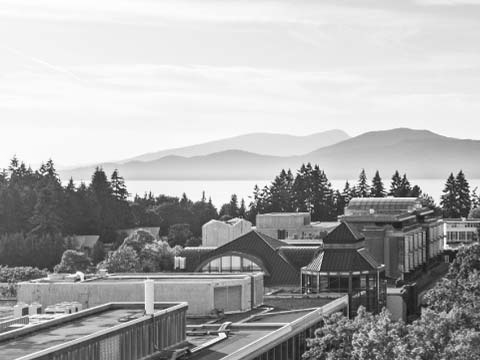

In [45]:
using Images, FileIO
orig_img = load(download("https://www.ubc.ca/_assets/img/about-ubc/about_ubc-1200x438.jpg"))
x, y = 1, 1
w, h = 480, 360
orig_img = Gray.(orig_img[y:y+h-1, x:x+w-1])

In [46]:
uncompressed = uncompressed_bytes(orig_img)
uncompressed_size = length(uncompressed)
println("Uncompressed size: $uncompressed_size")

Uncompressed size: 172800


In [47]:
compressed = Vector{UInt8}(encode_image(orig_img))
compressed_size = length(compressed)
println("Compressed size: $compressed_size")

Compressed size: 11650


In [48]:
save("480x360_orig.png", orig_img)

0

In [49]:
compressed_raw = Vector{UInt8}([])
encode_scan(compressed_raw, orig_img)
open("480x360_compressed_raw.dat", "w") do io
    write(io, compressed_raw)
end

11338

In [50]:
open("480x360_raw.dat", "w") do io
    write(io, uncompressed)
end

172800

In [51]:
open("480x360_compressed.jpg", "w") do io
    write(io, compressed)
end

11650

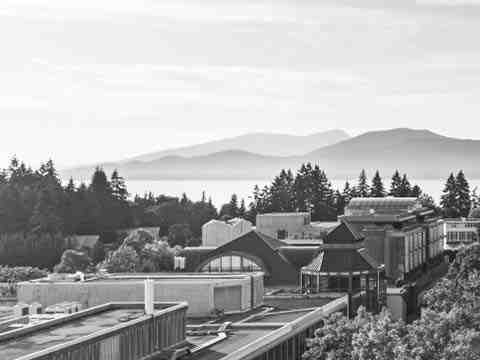

In [52]:
load("480x360_compressed.jpg")